# Detect Vessel Collisions
Now that we have our pipeline for taking a video of a microscope view of the brain during surgery and performing crops, color thresholding to produce masks, and recombining those back into gifs, its time to begin constructing the simulation in which our learner will live!

The first and most critical component of our simulation is to detect when the agent has selected a "lacing" site that collides with blood vasculature. This is my testing ground to figure out how to implement that

In [2]:
# ROS Kinetic Interferes with cv2 import

import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [3]:
import math
import cv2
import argparse
import collections
import numpy as np
from numpy import savetxt
from fastai.vision import *
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

import os 
import glob
import imageio

In [4]:
# Useful function that was constructed the preserve the order of images since each image is related by the time
# dimension. 
def order_files_by_date(path_to_folder, file_type):
    files = glob.glob("%s*%s" % (path_to_folder, file_type))
    files.sort(key=os.path.getmtime)
    return files

In [5]:
top_squares = order_files_by_date(
    "/home/andrew/Github/neuralink-bot/Image_Segmentation/segmented_images/square_segmentation_crops/top_crop/", 
    ".jpg")

left_squares = order_files_by_date(
    "/home/andrew/Github/neuralink-bot/Image_Segmentation/segmented_images/square_segmentation_crops/left_crop/", 
    ".jpg")

right_squares =order_files_by_date(
    "/home/andrew/Github/neuralink-bot/Image_Segmentation/segmented_images/square_segmentation_crops/right_crop/", 
    ".jpg")

# Load Test Image

In [41]:
def get_example(image_files, index):
    img = cv2.imread(image_files[index])
    img[vessel_img > 150] = 255
    img[vessel_img < 150] = 0
    print(f"Shape: {img.shape}, Size: {img.size}, Unique: {np.unique(img)}")
    return img

In [42]:
vessel_img = get_example(left_squares, 0)

Shape: (150, 150, 3), Size: 67500, Unique: [  0 255]


In [8]:
def euc_dist(p1, p2):
    return  math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )

In [13]:
def black_pixel_bool(vessel_img, i, j):
    if vessel_img[i][j][0] == 255 and vessel_img[i][j][1] == 255 and vessel_img[i][j][2] == 255:
        return True
    else:
        return False

In [114]:
thread_x = 95
thread_y = 95

distances = []

def compute_nearest_vessel(thread, vessel_img):
    for i in range(len(vessel_img)):
        for j in range(len(vessel_img)):
            if black_pixel_bool(vessel_img, i , j) == True:
                result = euc_dist([i, j], [thread_x, thread_y]) 
                distances.append(result)

In [115]:
compute_nearest_vessel('thread', vessel_img)

In [116]:
print(np.argmin(distances))

11931


In [48]:
class Distances(dict):
    def __init__(self):
        self = dict()
    
    def add(self, key, value):
        self[key] = value
        
distance_obj = Distances()

def compute_nearest_vessel_custom(vessel_img, thread_x, thread_y):
    for i in range(len(vessel_img)):
        for j in range(len(vessel_img)):
            if black_pixel_bool(vessel_img, i , j) == True:
                result = euc_dist([i, j], [thread_x, thread_y]) 
                distance_obj.add(result, [i, j])

In [124]:
compute_nearest_vessel_custom(vessel_img, 140, 20)
import collections
od = collections.OrderedDict(sorted(distance_obj.items()))

In [65]:
def compute_nearest_vessel_custom(distance, vessel_img, thread_x, thread_y):
    for i in range(len(vessel_img)):
        for j in range(len(vessel_img)):
            if black_pixel_bool(vessel_img, i , j) == True:
                result = euc_dist([i, j], [thread_y, thread_x]) 
                
                distance.add(result, [i, j])
    return distance
                
distances_2 = Distances()
compute_nearest_vessel_custom(distances_2, vessel_img, 125, 40)
distances_2

{131.24404748406687: [147, 49],
 130.29197979921864: [80, 1],
 129.34063553268942: [80, 2],
 128.39003076563228: [80, 3],
 127.4401820463232: [140, 46],
 126.49110640673517: [112, 21],
 125.54282137979854: [80, 6],
 124.59534501738017: [80, 7],
 123.64869590901475: [80, 8],
 122.70289320142373: [80, 9],
 121.75795661885921: [108, 24],
 120.81390648431164: [80, 11],
 119.87076374162301: [80, 12],
 118.92854997854805: [80, 13],
 117.98728745080972: [80, 14],
 117.04699910719626: [138, 61],
 116.1077086157504: [99, 25],
 115.16944039110375: [80, 17],
 114.23221962301179: [80, 18],
 113.29607230614837: [80, 19],
 112.36102527122117: [100, 30],
 111.42710621747295: [80, 21],
 110.4943437466371: [87, 25],
 109.5627673984187: [80, 23],
 108.63240768757728: [80, 24],
 107.70329614269008: [96, 33],
 106.77546534667971: [80, 26],
 105.84894897919393: [80, 27],
 104.92378186092989: [80, 28],
 104.0: [80, 29],
 103.07764064044152: [105, 45],
 102.15674231297707: [80, 31],
 101.23734488813898: [108

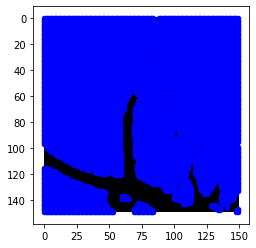

In [74]:
implot = plt.imshow(vessel_img)

# put a red dot, size 40, at 2 locations:
plt.scatter(x=[140], y=[20], c='r', s=40)
for i in range(len(vessel_img)):
    for j in range(len(vessel_img)):
        if black_pixel_bool(vessel_img, i , j) == True:
            plt.scatter(x=[j], y=[i], c='b', s=20)
# for val in distances_2.values():
#     plt.scatter(x=[val[0]], y=[val[1]], c='b', s=40)

plt.show()